## Builds a model for vectorizing the raw data (apply it once on train and once on test) :
* pivot from the initial feature_name:feature_value form to a vector
* handle dummy variables: translate categoric variables into N-1 dummy variables (The model is based on categories in train data)
* handle time-series variables: reduce them in several hard-coded methods
* fill missing values with train data means, and normalize to z-scores with train data std


In [1]:
from IPython.display import display

import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from vectorizing_funcs import *

In [2]:
df = pd.read_csv('../all_data.csv', sep = '|', error_bad_lines=False, index_col=False, dtype='unicode')
df.head()

,SubjectID,form_name,feature_name,feature_value,feature_unit,feature_delta
0,533,Demographic,Gender,F,NaN,0.0
1,533,Demographic,Age,65,NaN,0.0
2,533,Demographic,Race,White,NaN,0.0
3,533,ALSHX,onset_delta,-1023,NaN,0.0
4,533,ALSHX,diag_delta,-44,NaN,0.0


# Build metadata: assign features to vectorizing functions
funcs_to_features arrays define pairs of funcs (can be a list of functions or a single one) and features that should get these functions calculated. Overlapping is allowed.

There is a list for time-series functions (as described before) and for dummy functions. Both are inverted to feature_to_funcs maps.

In [3]:
ts_funcs_to_features = add_frequent_lab_tests_to_ts_features(df, ts_funcs_to_features)    
all_feature_metadata = invert_func_to_features(ts_funcs_to_features, "ts")
all_feature_metadata.update(invert_func_to_features(dummy_funcs_to_features, "dummy"))

## Learn to_dummies model
Which kind of categories do we have available in our train data?

In [4]:
all_feature_metadata = learn_to_dummies_model(df, all_feature_metadata)

##Vectorize `train` data 

In [5]:

vectorized, all_feature_metadata = vectorize(df, all_feature_metadata, debug=True)
vectorized.head()


family_ALS_hist
onset_site
weight
Sodium
hands
pulse
White Blood Cell (WBC)
Albumin
Chloride
ALSFRS_Total
Glucose
Alkaline Phosphatase
bp_systolic
fvc_percent
Potassium
BMI
bp_diastolic
Blood Urea Nitrogen (BUN)
Phosphorus
CK
Gender
Age
respiratory_rate
Calcium
Race
mouth
Gamma-glutamyltransferase
Total Cholesterol
onset_delta
Bilirubin (Total)
Creatinine
temperature
respiratory
AST(SGOT)
Hemoglobin
Platelets
if_use_Riluzole
Protein
ALT(SGPT)


,family_ALS_hist_last,Bulbar,Limb,Limb and Bulbar,weight_last,weight_mean_slope,weight_mean,weight_pct_diff,Sodium_last,Sodium_mean_slope,...,Platelets_pct_diff,if_use_Riluzole_last,Protein_last,Protein_mean_slope,Protein_mean,Protein_pct_diff,ALT(SGPT)_last,ALT(SGPT)_mean_slope,ALT(SGPT)_mean,ALT(SGPT)_pct_diff
SubjectID,,,,,,,,,,,,,,,,,,,,,
533,NaN,1,0,0,50.5,0.004337,51.000000,-0.000108,146,0.032967,...,-0.001105,NaN,69,-0.010989,69.5,-0.000157,24,0.065934,21.00,0.003663
649,NaN,1,0,0,74.4,0.035425,74.566667,0.000156,136,0.092037,...,-0.002510,1,73,0.058039,71.0,0.000549,25,-0.072383,17.00,0.007212
1234,NaN,1,0,0,96.0,0.012698,95.050000,0.000227,142,-0.095671,...,-0.000532,1,72,-0.181530,74.5,-0.001099,24,-0.100577,22.75,0.000621
2492,NaN,0,1,0,90.1,0.000000,90.100000,0.000000,139,0.029412,...,NaN,NaN,NaN,NaN,NaN,NaN,62,0.058824,61.00,0.000980
2956,NaN,0,1,0,65.3,-0.032251,65.100000,-0.000059,142,0.012987,...,0.000281,0,75,0.096681,73.5,0.000732,28,-0.050505,25.25,0.001558


In [6]:
vectorized.describe().transpose().sort("count", ascending=True)

,count,mean,std,min,25%,50%,75%,max
family_ALS_hist_last,346,0.208092,0.406531,0.000000,0.000000,0.000000,0.000000,1.000000
temperature_pct_diff,454,0.000047,0.001412,-0.001936,-0.000190,0.000000,0.000101,0.026853
temperature_mean_slope,454,0.000713,0.056535,-0.200714,-0.013833,-0.002532,0.007399,0.909242
temperature_mean,457,36.563308,0.755195,31.700000,36.333333,36.580000,36.800000,49.240000
temperature_last,457,36.654184,2.948809,34.500000,36.200000,36.600000,36.900000,98.600000
BMI_last,1280,0.002577,0.000436,0.001528,0.002267,0.002518,0.002826,0.004731
CK_pct_diff,1423,0.005245,0.012222,-0.039435,-0.000822,0.002551,0.007517,0.171150
CK_mean_slope,1423,1.293199,10.441481,-66.363194,-0.492879,0.577354,2.311193,249.280809
Gamma-glutamyltransferase_mean_slope,1539,0.017835,0.942537,-14.450537,-0.071429,0.030719,0.167995,12.385714
Gamma-glutamyltransferase_pct_diff,1539,0.001713,0.007553,-0.026243,-0.001616,0.000442,0.003206,0.155012


## Filling empty values with means and normalizing
- NOTE that we have to use the `train` data means and std

In [13]:
vectorized[[col for col in vectorized.columns if "Crea" in col]].describe().transpose().sort("count", ascending=True)

,count,mean,std,min,25%,50%,75%,max
Creatinine_mean_slope,1869,-0.186601,1.019224,-17.568933,-0.231164,-0.002646,0.110680,4.544464
Creatinine_pct_diff,1869,0.027645,1.211326,-0.020833,-0.001821,0.000000,0.000544,52.367476
Creatinine_last,2183,68.704779,18.615707,17.680000,55.000000,68.000000,79.560000,265.200000
Creatinine_mean,2183,69.623261,17.224775,19.250000,58.245000,68.510000,79.600000,212.160000


In [34]:
train_data_means = vectorized.mean()
train_data_std = vectorized.std()            
normalized, all_feature_metadata = normalize(vectorized, all_feature_metadata, train_data_means, train_data_std)
normalized.describe().T.sort("max", ascending=False).head(10)


,count,mean,std,min,25%,50%,75%,max
Creatinine_pct_diff,2205,4.212900e-17,0.920625,-0.040021,-0.024112,-0.022822,-0.021052,43.208702
AST(SGOT)_last,2205,-1.024879e-16,0.995225,-1.122514,-0.370865,-0.149791,0.203926,38.891753
Total Cholesterol_pct_diff,2205,4.502571e-17,0.835629,-0.667319,-0.068817,0.000000,0.008061,38.824012
Hemoglobin_mean_slope,2205,-5.926854e-17,0.872550,-4.852866,-0.080938,0.000000,0.095623,33.572081
ALT(SGPT)_last,2205,6.724905e-18,0.995452,-1.019824,-0.485900,-0.201140,0.225999,32.332642
Protein_pct_diff,2205,4.043125e-17,0.848025,-6.753089,-0.230995,0.000000,0.166560,30.943341
Potassium_mean,2205,-7.360804e-15,0.994997,-2.623790,-0.454635,-0.039070,0.344528,30.217982
Calcium_pct_diff,2205,4.449113e-17,0.848293,-2.864150,-0.123045,-0.005941,0.000000,27.911746
AST(SGOT)_mean,2205,2.718108e-15,0.995225,-1.595167,-0.528626,-0.188240,0.333684,26.824750
Calcium_mean_slope,2205,-5.186076e-17,0.848293,-13.177524,-0.119916,0.000000,0.039787,26.437502


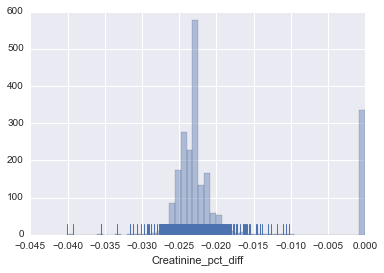

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

cre = normalized[normalized.Creatinine_pct_diff < 3].Creatinine_pct_diff
sns.distplot(cre, rug=True, kde=False);

## Pickle all metadata we will need to use later when applying vectorizer

In [17]:
pickle.dump( all_feature_metadata, open('../all_feature_metadata.pickle', 'wb') )
pickle.dump( train_data_means, open('../all_data_means.pickle', 'wb') )
pickle.dump( train_data_std, open('../all_data_std.pickle', 'wb') )


## Apply model on `train`,  `test` 


In [18]:

for t in ["all", "test"]:
    df = pd.read_csv('../' + t + '_data.csv', sep = '|', error_bad_lines=False, index_col=False, dtype='unicode')
    vectorized, _ = vectorize(df, all_feature_metadata)
    normalized, _ = normalize(vectorized, all_feature_metadata, train_data_means, train_data_std)
    print t, normalized.shape
    normalized.to_csv('../' + t + '_data_vectorized.csv' ,sep='|')

normalized.head()

all (2205, 140)
test (600, 140)


,family_ALS_hist_last,Bulbar,Limb,Limb and Bulbar,weight_last,weight_mean_slope,weight_mean,weight_pct_diff,Sodium_last,Sodium_mean_slope,...,Platelets_pct_diff,if_use_Riluzole_last,Protein_last,Protein_mean_slope,Protein_mean,Protein_pct_diff,ALT(SGPT)_last,ALT(SGPT)_mean_slope,ALT(SGPT)_mean,ALT(SGPT)_pct_diff
SubjectID,,,,,,,,,,,,,,,,,,,,,
750059,0,-0.501303,0.512608,-0.085475,2.136302,0.015749,2.061448,0.267218,-1.797715,0.601348,...,-0.459575,-1.403994,-0.776848,0.589301,-0.901735,0.407644,0.225999,0.179300,-0.183170,0.648286
750094,0,-0.501303,0.512608,-0.085475,-0.577366,0.762399,-0.680211,1.355411,0.081373,0.396271,...,-0.443557,-1.403994,-0.308146,-0.325235,0.057526,-0.594551,-0.307925,0.148785,-0.380253,-0.073179
750148,0,1.993896,-1.949922,-0.085475,-1.161351,-1.722087,-1.340747,0.107964,-1.421897,0.133763,...,-0.013086,0.711884,0.394909,0.175925,-0.024696,0.155231,-0.663874,-0.384791,-0.121892,-0.892634
750195,0,1.993896,-1.949922,-0.085475,1.333279,-0.552968,1.376093,-0.632499,0.081373,0.139004,...,2.080883,-1.403994,0.394909,-0.999048,-0.390129,1.343320,-0.379115,2.170999,0.037100,-1.523329
750406,0,-0.501303,0.512608,-0.085475,0.647732,0.705334,0.457092,2.105849,0.081373,0.258216,...,-0.171343,0.711884,1.097963,-1.115379,2.039998,-1.366227,-0.628279,0.003152,-0.820793,-0.123625
